<a href="https://colab.research.google.com/github/mz-zarei/CGAN-Augmentation/blob/main/CGAN_data_augmentation_WA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libs**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import nbeb
import importlib
import numpy as np
import random
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import kendalltau, pearsonr, spearmanr
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU, ELU, ReLU, concatenate
from keras.layers import Dropout
from matplotlib import pyplot
from keras import Input, Model
import keras
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

random.seed(1)
np.random.seed(1)

# **Preparing Crash Data**

In [ ]:
## Importing Data
y_name = 'FI'
Path_to_data = "/content/drive/MyDrive/GAN_regression/ganRegression/UrbanFreeWay4laneDivided.xlsx"

all_data = pd.read_excel(Path_to_data)
print(f'Columns: {all_data.columns}')
all_data.sort_values(by=['ID'])

# data['TERRAIN'].describe()
all_data.groupby('year').FI.describe().round(2)
# data.describe().round(2)

Columns: Index(['RURURB', 'TERRAIN', 'LSHLDWID', 'LSHL_WD2', 'MEDWID', 'NO_LANES',
       'RSHLDWID', 'RSHL_WD2', 'SEG_LNG', 'lanewid', 'AADT', 'year', 'RSW_r',
       'LSW_r', 'Divided', 'rodwycls', 'Class', 'Class2', 'ID', 'PDO', 'Fatal',
       'Injury', 'FI', 'TotalCrash'],
      dtype='object')


,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2012,3085.0,0.22,0.76,0.0,0.0,0.0,0.0,17.0
2013,3085.0,0.20,0.71,0.0,0.0,0.0,0.0,11.0
2014,3085.0,0.23,0.82,0.0,0.0,0.0,0.0,15.0
2015,3085.0,0.26,0.87,0.0,0.0,0.0,0.0,19.0
2016,3085.0,0.29,0.97,0.0,0.0,0.0,0.0,23.0
2017,3085.0,0.28,0.85,0.0,0.0,0.0,0.0,16.0


In [ ]:
# Keep data for the last two years
data = all_data[all_data["year"] < 2014].copy()
data = data.reset_index(drop=True)

# Feature transformations
data['log_AADT'] = np.log(data["AADT"])
data['SEG_LNG'] = data['SEG_LNG'] * 1.609                    # mile to km
data['log_L'] = np.log(data['SEG_LNG'])
data['MED_dummy'] = [1 if m > 10 else 0 for m in data.MEDWID.values]
data['LSW_dummy'] = [1 if m > 0 else 0 for m in data.LSHLDWID.values]
data['RSW_dummy'] = [1 if m > 0 else 0 for m in data.RSHLDWID.values]

# Terrain_one_hot = pd.get_dummies(data.TERRAIN, prefix='TERRAIN')
# data[Terrain_one_hot.columns.to_list()] = Terrain_one_hot

x_features = ['LSW_dummy','MED_dummy','RSW_dummy','log_AADT', 'log_L']

# Split train and test data sets
random.seed(50)
test_ids = random.sample(set(data['ID'].unique()), 585)
train_data = data.loc[~data['ID'].isin(test_ids)].copy()
test_data = data.loc[data['ID'].isin(test_ids)].copy()

x_data = train_data[x_features].astype(np.float)  
y_data = train_data[y_name].astype(np.float)

print(f'X data shape: {x_data.shape}, y data shape: {y_data.shape}')
data[['LSHLDWID','MEDWID','RSHLDWID','AADT', 'SEG_LNG', 'FI']].describe().round(2)

X data shape: (5000, 5), y data shape: (5000,)


,LSHLDWID,MEDWID,RSHLDWID,AADT,SEG_LNG,FI
count,6170.00,6170.00,6170.00,6170.00,6170.00,6170.00
mean,2.15,40.07,8.55,44440.86,0.13,0.21
std,2.47,41.61,3.55,26958.45,0.19,0.74
min,0.00,2.00,0.00,4328.00,0.02,0.00
25%,0.00,16.00,10.00,24315.00,0.03,0.00
50%,0.00,40.00,10.00,40808.00,0.06,0.00
75%,4.00,48.00,10.00,58206.00,0.16,0.00
max,22.00,750.00,24.00,170716.00,3.25,17.00


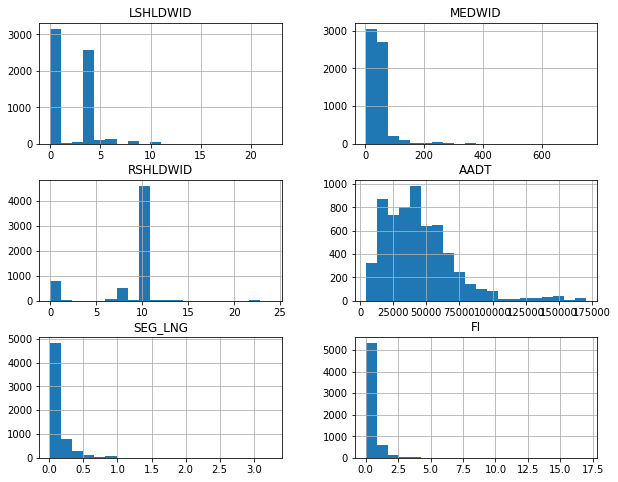

In [ ]:
ax = data[['LSHLDWID', 'MEDWID', 'RSHLDWID','AADT', 'SEG_LNG', 'FI']].hist(bins = 20, figsize=(10, 8))

# **Fit NB model (Truth)**

In [ ]:
x_features = ['LSW_dummy','MED_dummy','RSW_dummy','log_AADT', 'log_L']
significant_features = nbeb.backward_regression(train_data, x_features, 
                                            y_name=y_name, threshold_out=0.05, 
                                            verbose=False)
NB_model, alpha  = nbeb.fitNB(train_data, significant_features, y_name=y_name)

print(f"Dispersion: {alpha:0.2f}")
print(NB_model.summary2())

Dispersion: 0.84
               Results: Generalized linear model
Model:              GLM              AIC:            4356.2435  
Link Function:      log              BIC:            -40318.3955
Dependent Variable: FI               Log-Likelihood: -2172.1    
Date:               2022-07-25 16:39 LL-Null:        -2834.5    
No. Observations:   5000             Deviance:       2216.5     
Df Model:           5                Pearson chi2:   5.07e+03   
Df Residuals:       4994             Scale:          1.0000     
Method:             IRLS                                        
----------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------
const        -13.1927   0.7767 -16.9850 0.0000 -14.7151 -11.6704
LSW_dummy     -0.2150   0.0856  -2.5127 0.0120  -0.3827  -0.0473
MED_dummy     -0.6388   0.1192  -5.3581 0.0000  -0.8725  -0.4051
RSW_dummy     -0.3616   